In [3]:
# %% [markdown]
"""
# Semi-Supervised Learning for Materials Science: A Detailed Python Notebook

This notebook demonstrates a semi-supervised learning approach applied to a materials science problem.
We simulate a synthetic dataset where each sample represents a material characterized by several features,
and the task is to classify materials (for example, as "Conductive" or "Insulating"). In many real-world
scenarios in materials science, experimental data is expensive and hard to label, so semi-supervised
techniques that leverage a large amount of unlabeled data are particularly valuable.

Throughout this notebook, we generate plots to visualize the data, the learned decision boundaries, and
the performance of different models. We compare a semi-supervised approach (using LabelSpreading)
with a fully supervised model trained only on the limited labeled data.

Let's begin by importing the necessary libraries.
"""

'\n# Semi-Supervised Learning for Materials Science: A Detailed Python Notebook\n\nThis notebook demonstrates a semi-supervised learning approach applied to a materials science problem.\nWe simulate a synthetic dataset where each sample represents a material characterized by several features,\nand the task is to classify materials (for example, as "Conductive" or "Insulating"). In many real-world\nscenarios in materials science, experimental data is expensive and hard to label, so semi-supervised\ntechniques that leverage a large amount of unlabeled data are particularly valuable.\n\nThroughout this notebook, we generate plots to visualize the data, the learned decision boundaries, and\nthe performance of different models. We compare a semi-supervised approach (using LabelSpreading)\nwith a fully supervised model trained only on the limited labeled data.\n\nLet\'s begin by importing the necessary libraries.\n'

In [4]:
# %% [code]
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.semi_supervised import LabelSpreading
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from matplotlib.colors import ListedColormap

# Set random seed for reproducibility
np.random.seed(42)
#plt.style.use('seaborn-whitegrid')
print("Libraries imported successfully.")

Libraries imported successfully.


In [5]:
# %% [markdown]
"""
# Cell 2: Generate Synthetic Materials Science Dataset

In this cell, we generate a synthetic dataset that mimics a typical materials science problem.
We simulate 2-dimensional data (for visualization ease) with two informative features. The labels
will represent two classes (e.g., "Conductive" vs. "Insulating"). To simulate the challenge in
materials science, we artificially remove labels for a large portion of the dataset.
"""

# %% [code]
# Cell 2: Generate Synthetic Data
# We create a binary classification dataset with 1000 samples and 2 informative features.
n_samples = 1000
n_features = 2  # for visualization purposes (could be extended)
n_informative = 2
n_redundant = 0
n_clusters = 2

X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative,
                           n_redundant=n_redundant, n_clusters_per_class=n_clusters, flip_y=0.05,
                           class_sep=1.5, random_state=42)

# Convert to DataFrame for better handling and visualization
df = pd.DataFrame(X, columns=['Feature_1', 'Feature_2'])
df['True_Label'] = y

# Simulate semi-supervised scenario: Only 30% of the labels are known
# The remaining 70% will be set as -1, indicating unlabeled data.
n_labeled = int(0.3 * n_samples)
indices = np.random.choice(n_samples, n_labeled, replace=False)
y_semi = -np.ones(n_samples, dtype=int)
y_semi[indices] = y[indices]
df['Semi_Label'] = y_semi

print(f"Total samples: {n_samples}")
print(f"Number of labeled samples: {n_labeled}")
print("Synthetic dataset generated.")

Total samples: 1000
Number of labeled samples: 300
Synthetic dataset generated.


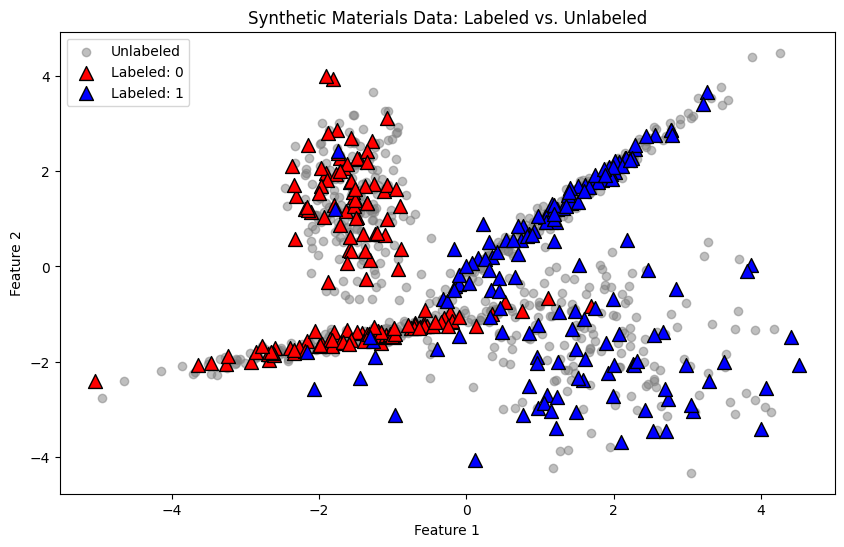

In [6]:
# %% [markdown]
"""
# Cell 3: Visualize the Synthetic Dataset

We now visualize the dataset. The plot below shows all the data points in the 2D feature space.
Labeled samples are shown in distinct colors while unlabeled ones appear in gray.
This gives us an intuition about the distribution of the data and the potential clusters.
"""

# %% [code]
# Cell 3: Data Visualization
plt.figure(figsize=(10, 6))
# Plot unlabeled data points in gray
plt.scatter(df.loc[df['Semi_Label'] == -1, 'Feature_1'],
            df.loc[df['Semi_Label'] == -1, 'Feature_2'],
            c='gray', marker='o', label='Unlabeled', alpha=0.5)

# Plot labeled data points in color (red and blue)
for label, color in zip([0, 1], ['red', 'blue']):
    subset = df[(df['Semi_Label'] == label)]
    plt.scatter(subset['Feature_1'], subset['Feature_2'],
                c=color, marker='^', edgecolor='k', s=100,
                label=f'Labeled: {label}')

plt.title("Synthetic Materials Data: Labeled vs. Unlabeled")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [7]:
# %% [markdown]
"""
# Cell 4: Apply Semi-Supervised Learning (LabelSpreading)

Here we apply the LabelSpreading algorithm from scikit-learn, which is well-suited for semi-supervised
learning problems. The algorithm propagates labels from the few labeled samples to the unlabeled ones
based on the similarity of feature values.
"""

# %% [code]
# Cell 4: Semi-Supervised Learning with LabelSpreading
# Initialize the LabelSpreading model
label_spread = LabelSpreading(kernel='rbf', gamma=20, max_iter=30)
label_spread.fit(X, y_semi)

# Predict the labels for all data points
y_pred = label_spread.transduction_

# Add the predicted labels to the DataFrame
df['Predicted_Label'] = y_pred

print("LabelSpreading applied. Predicted labels for all data points obtained.")

LabelSpreading applied. Predicted labels for all data points obtained.


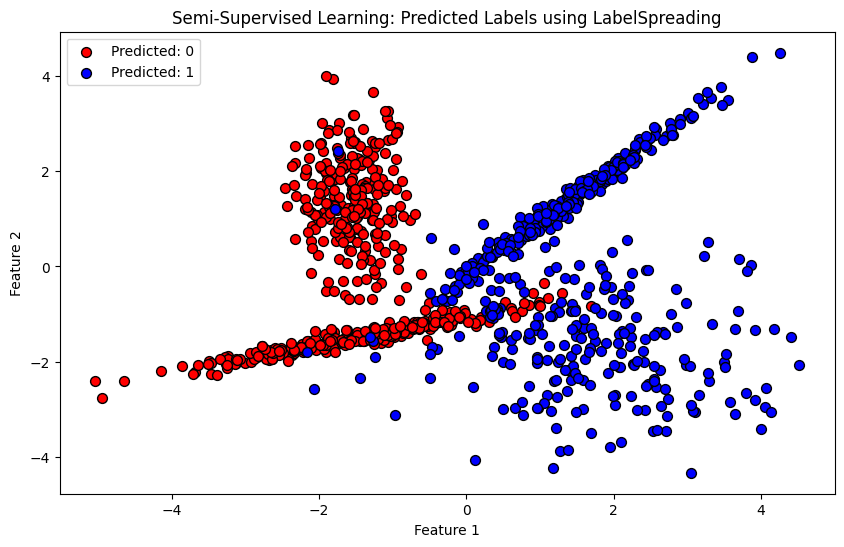

In [8]:
# %% [markdown]
"""
# Cell 5: Visualize Semi-Supervised Learning Results

We now visualize the results of the semi-supervised learning. The plot shows the data colored according
to the predicted labels from the LabelSpreading model. Notice how the unlabeled data has been effectively
labeled by propagating information from the few labeled samples.
"""

# %% [code]
# Cell 5: Visualization of Predicted Labels
plt.figure(figsize=(10, 6))
# Use predicted labels to color the entire dataset
for label, color in zip([0, 1], ['red', 'blue']):
    subset = df[df['Predicted_Label'] == label]
    plt.scatter(subset['Feature_1'], subset['Feature_2'],
                c=color, marker='o', edgecolor='k', s=50,
                label=f'Predicted: {label}')

plt.title("Semi-Supervised Learning: Predicted Labels using LabelSpreading")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

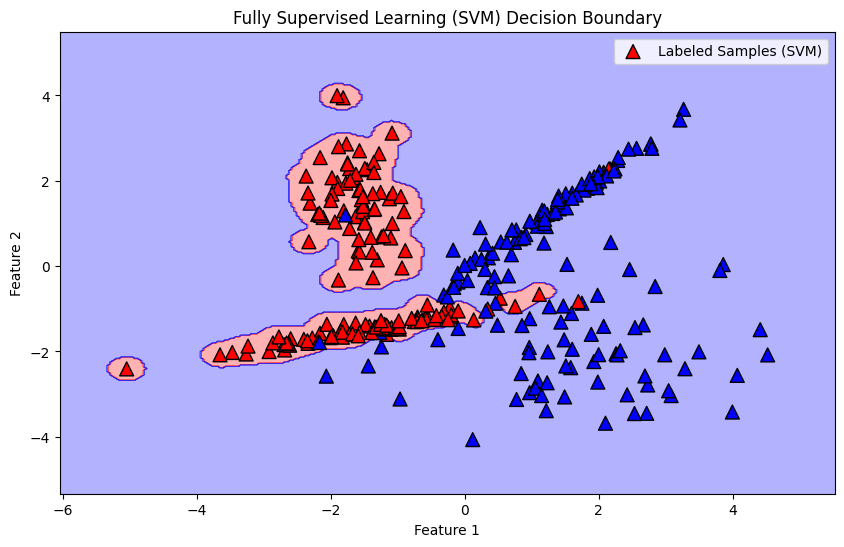

In [9]:
# %% [markdown]
"""
# Cell 6: Fully Supervised Learning Comparison

For comparison, we now train a fully supervised classifier (Support Vector Machine) on only the limited labeled
data. We then visualize its decision boundary and compare it to the semi-supervised results.
"""

# %% [code]
# Cell 6: Fully Supervised Learning with SVM
# Extract only the labeled samples
X_labeled = X[y_semi != -1]
y_labeled = y[y_semi != -1]

# Train a Support Vector Machine classifier
svm_clf = SVC(kernel='rbf', gamma=20, probability=True)
svm_clf.fit(X_labeled, y_labeled)

# Create a mesh grid for plotting decision boundaries
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

# Predict on the mesh grid
Z = svm_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['red', 'blue']))
plt.scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, cmap=ListedColormap(['red', 'blue']),
            marker='^', edgecolor='k', s=100, label="Labeled Samples (SVM)")
plt.title("Fully Supervised Learning (SVM) Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

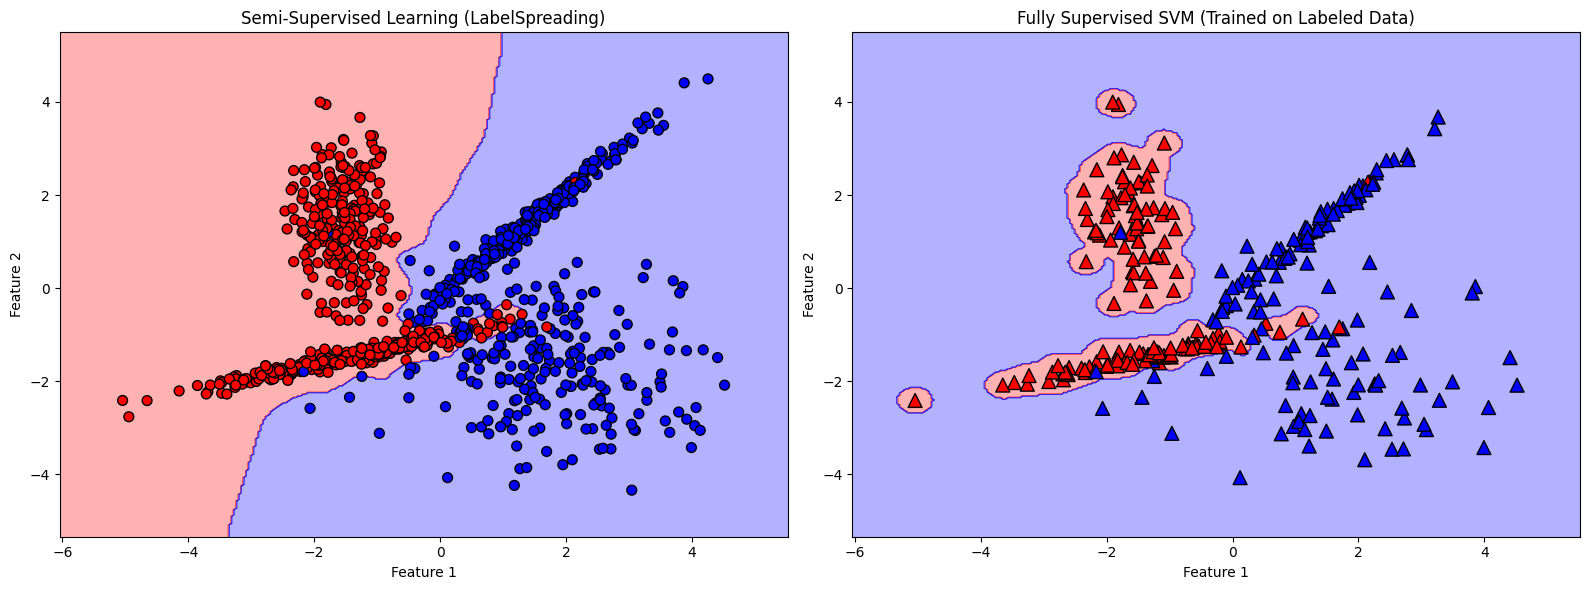

In [10]:
# %% [markdown]
"""
# Cell 7: Compare Decision Boundaries

In this cell, we plot side-by-side decision boundaries from the semi-supervised model (LabelSpreading)
and the fully supervised SVM model. This comparison highlights how the semi-supervised method uses the
unlabeled data to refine its decision boundaries.
"""

# %% [code]
# Cell 7: Decision Boundary Comparison

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for semi-supervised learning (LabelSpreading)
ax = axes[0]
Z_semi = label_spread.predict(np.c_[xx.ravel(), yy.ravel()])
Z_semi = Z_semi.reshape(xx.shape)
ax.contourf(xx, yy, Z_semi, alpha=0.3, cmap=ListedColormap(['red', 'blue']))
ax.scatter(X[:, 0], X[:, 1], c=y_pred, cmap=ListedColormap(['red', 'blue']),
           marker='o', edgecolor='k', s=50)
ax.set_title("Semi-Supervised Learning (LabelSpreading)")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

# Plot for fully supervised SVM
ax = axes[1]
ax.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['red', 'blue']))
ax.scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, cmap=ListedColormap(['red', 'blue']),
           marker='^', edgecolor='k', s=100)
ax.set_title("Fully Supervised SVM (Trained on Labeled Data)")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

Accuracy of LabelSpreading: 0.95

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       501
           1       0.96      0.95      0.95       499

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000

Confusion Matrix:
[[481  20]
 [ 26 473]]


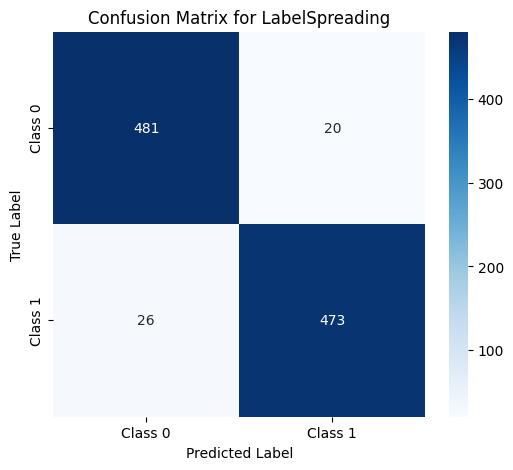

In [11]:
# %% [markdown]
"""
# Cell 8: Evaluation Metrics and Confusion Matrix

Next, we evaluate the performance of our semi-supervised model using standard classification metrics.
We compute accuracy, print a classification report, and display a confusion matrix.
"""

# %% [code]
# Cell 8: Model Evaluation
# Ground truth labels for evaluation (using the true labels for all data)
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy of LabelSpreading: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix for LabelSpreading")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

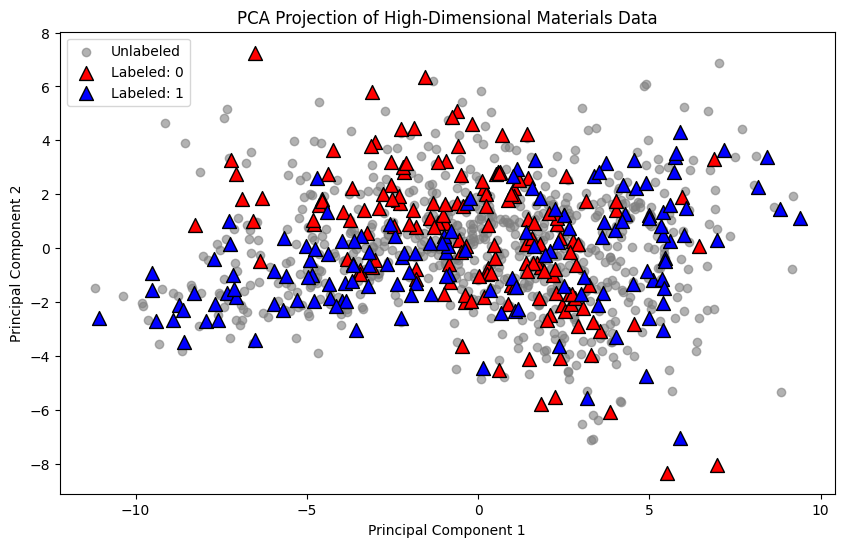

In [12]:
# %% [markdown]
"""
# Cell 9: Principal Component Analysis (PCA) for High-Dimensional Visualization

In many materials science problems, the data is high-dimensional. PCA can help us visualize the structure
of the data in a 2D space. In this cell, we use PCA to reduce the feature space (even though our data is
2D here, this cell demonstrates how to handle higher dimensions) and plot the clusters.
"""

# %% [code]
# Cell 9: PCA Visualization
# For demonstration, we generate a higher-dimensional dataset and reduce it to 2D using PCA.
n_features_hd = 10  # Simulate 10 features for a more complex dataset
X_hd, y_hd = make_classification(n_samples=n_samples, n_features=n_features_hd,
                                 n_informative=5, n_redundant=2, n_clusters_per_class=2,
                                 class_sep=1.2, flip_y=0.1, random_state=42)

# Introduce unlabeled data (30% labeled)
y_hd_semi = -np.ones(n_samples, dtype=int)
hd_indices = np.random.choice(n_samples, int(0.3 * n_samples), replace=False)
y_hd_semi[hd_indices] = y_hd[hd_indices]

# Apply PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_hd_pca = pca.fit_transform(X_hd)

# Create a DataFrame for visualization
df_hd = pd.DataFrame(X_hd_pca, columns=['PC1', 'PC2'])
df_hd['True_Label'] = y_hd
df_hd['Semi_Label'] = y_hd_semi

plt.figure(figsize=(10, 6))
# Plot unlabeled points
plt.scatter(df_hd.loc[df_hd['Semi_Label'] == -1, 'PC1'],
            df_hd.loc[df_hd['Semi_Label'] == -1, 'PC2'],
            c='gray', marker='o', label='Unlabeled', alpha=0.6)
# Plot labeled points
for label, color in zip([0, 1], ['red', 'blue']):
    subset = df_hd[df_hd['Semi_Label'] == label]
    plt.scatter(subset['PC1'], subset['PC2'],
                c=color, marker='^', edgecolor='k', s=100,
                label=f'Labeled: {label}')
plt.title("PCA Projection of High-Dimensional Materials Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

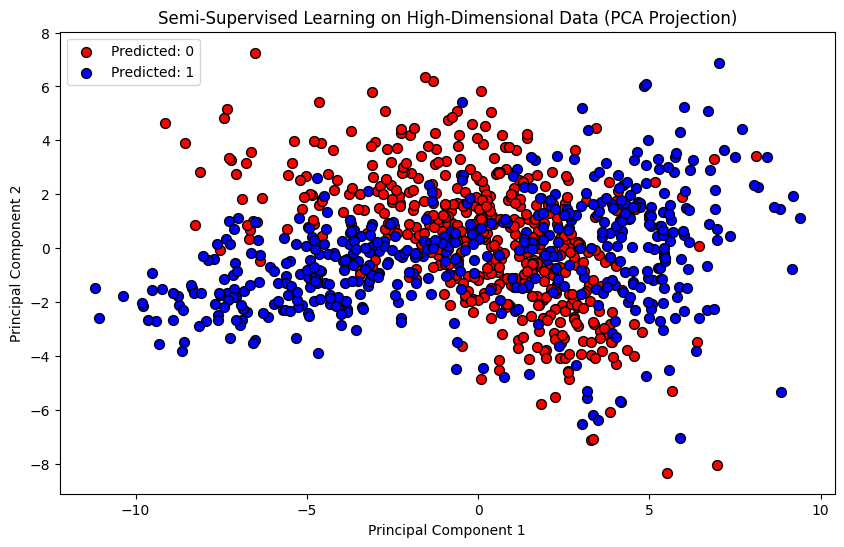

In [13]:
# %% [markdown]
"""
# Cell 10: Semi-Supervised Learning on High-Dimensional Data

We now apply the LabelSpreading algorithm on the high-dimensional data (using the original features)
and then visualize the results in the PCA-reduced 2D space.
"""

# %% [code]
# Cell 10: Semi-Supervised on High-Dimensional Data
label_spread_hd = LabelSpreading(kernel='knn', n_neighbors=7, max_iter=50)
label_spread_hd.fit(X_hd, y_hd_semi)

# Predict the labels
y_hd_pred = label_spread_hd.transduction_
df_hd['Predicted_Label'] = y_hd_pred

plt.figure(figsize=(10, 6))
for label, color in zip([0, 1], ['red', 'blue']):
    subset = df_hd[df_hd['Predicted_Label'] == label]
    plt.scatter(subset['PC1'], subset['PC2'],
                c=color, marker='o', edgecolor='k', s=50,
                label=f'Predicted: {label}')
plt.title("Semi-Supervised Learning on High-Dimensional Data (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

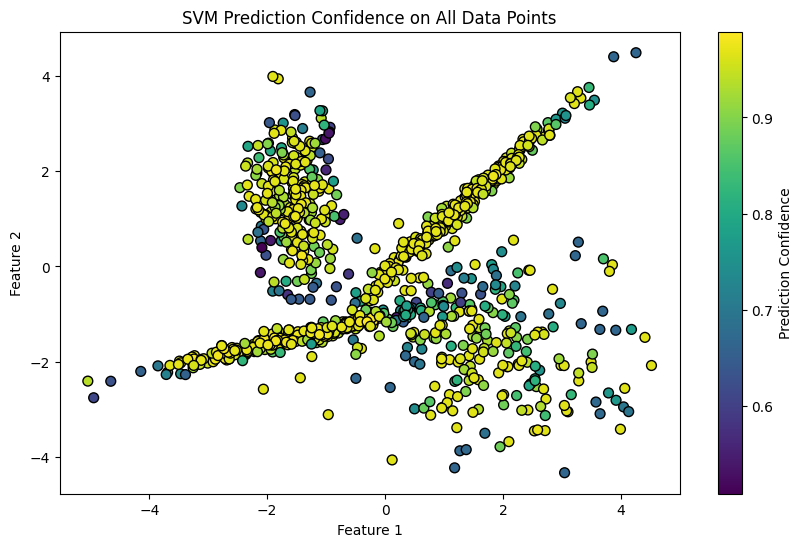

In [14]:
# %% [markdown]
"""
# Cell 11: Uncertainty Visualization

Understanding uncertainty in predictions is crucial in materials science, where incorrect predictions can
lead to costly experiments. Here we visualize the confidence scores (probabilities) of the SVM classifier
trained on the limited labeled data.
"""

# %% [code]
# Cell 11: Uncertainty in Supervised Learning
# Compute prediction probabilities for the SVM classifier on the entire dataset
probs = svm_clf.predict_proba(X)
confidence = np.max(probs, axis=1)

# Create a scatter plot where the color intensity represents the model's confidence
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=confidence, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.colorbar(scatter, label='Prediction Confidence')
plt.title("SVM Prediction Confidence on All Data Points")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

Number of unlabeled samples with confidence above 0.95: 341


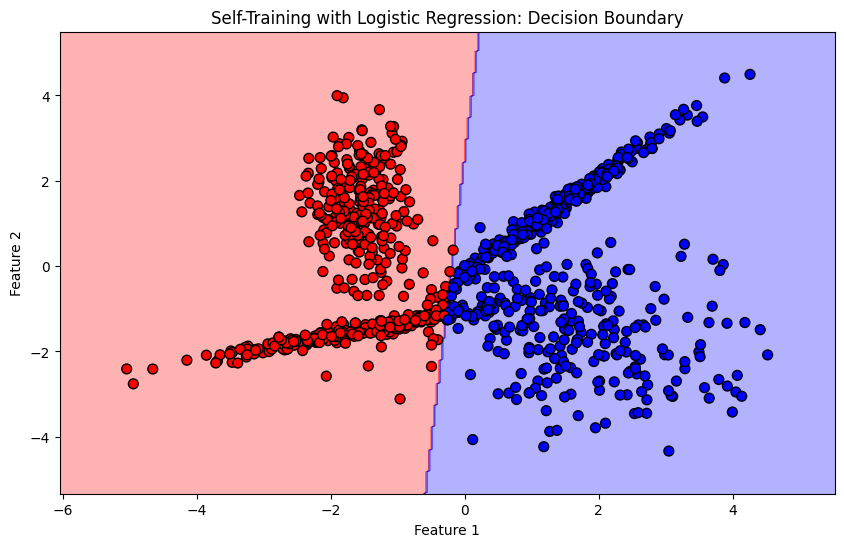

In [15]:
# %% [markdown]
"""
# Cell 12: Self-Training Simulation

An alternative semi-supervised approach is self-training. In self-training, we iteratively add
confident predictions to the training set and retrain the model. The code below simulates one iteration
of self-training using Logistic Regression.
"""

# %% [code]
# Cell 12: Self-Training Example with Logistic Regression
# Start with the limited labeled data
X_self_train = X_labeled.copy()
y_self_train = y_labeled.copy()

# Initialize a logistic regression classifier
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_self_train, y_self_train)

# Predict probabilities for the unlabeled data
X_unlabeled = X[y_semi == -1]
probs_unlabeled = lr.predict_proba(X_unlabeled)
confidence_unlabeled = np.max(probs_unlabeled, axis=1)

# Set a threshold for adding new labels
confidence_threshold = 0.95
new_indices = np.where(confidence_unlabeled > confidence_threshold)[0]

print(f"Number of unlabeled samples with confidence above {confidence_threshold}: {len(new_indices)}")

# Add new labels (simulate self-training step)
X_new = X_unlabeled[new_indices]
y_new = lr.predict(X_new)

# Augment the training set
X_self_train = np.concatenate([X_self_train, X_new], axis=0)
y_self_train = np.concatenate([y_self_train, y_new], axis=0)

# Retrain the logistic regression classifier on the augmented set
lr.fit(X_self_train, y_self_train)
y_self_pred = lr.predict(X)

# Plot the decision boundary of the self-trained model
xx_self, yy_self = np.meshgrid(np.linspace(x_min, x_max, 300),
                                np.linspace(y_min, y_max, 300))
Z_self = lr.predict(np.c_[xx_self.ravel(), yy_self.ravel()])
Z_self = Z_self.reshape(xx_self.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx_self, yy_self, Z_self, alpha=0.3, cmap=ListedColormap(['red', 'blue']))
plt.scatter(X[:, 0], X[:, 1], c=y_self_pred, cmap=ListedColormap(['red', 'blue']),
            marker='o', edgecolor='k', s=50)
plt.title("Self-Training with Logistic Regression: Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


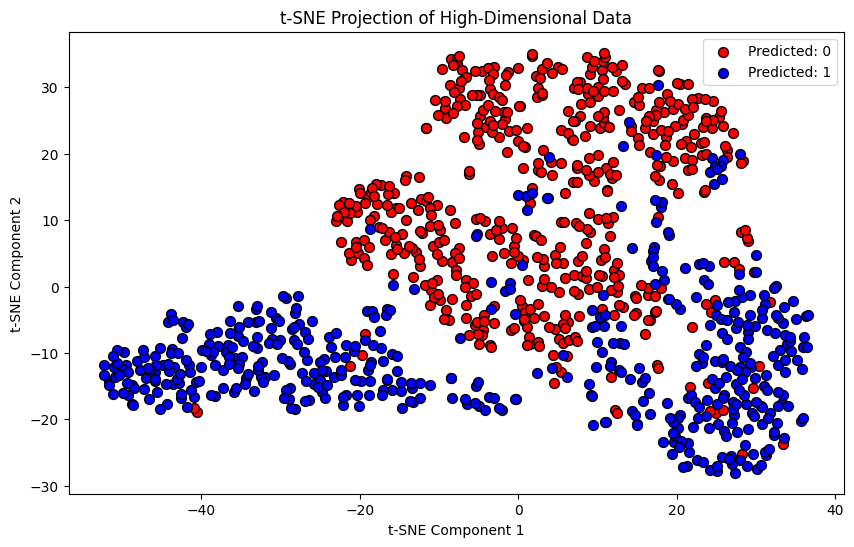

In [16]:
# %% [markdown]
"""
# Cell 13: In-Depth Analysis of Feature Space via t-SNE

For further exploration, we can use t-SNE to visualize the high-dimensional structure of the data.
t-SNE is particularly useful for understanding complex relationships that PCA might not reveal.
"""

# %% [code]
# Cell 13: t-SNE Visualization
from sklearn.manifold import TSNE

# Run t-SNE on the high-dimensional dataset (X_hd)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_hd)

# Create a DataFrame for t-SNE results
df_tsne = pd.DataFrame(X_tsne, columns=['tSNE_1', 'tSNE_2'])
df_tsne['True_Label'] = y_hd
df_tsne['Predicted_Label'] = label_spread_hd.transduction_

plt.figure(figsize=(10, 6))
for label, color in zip([0, 1], ['red', 'blue']):
    subset = df_tsne[df_tsne['Predicted_Label'] == label]
    plt.scatter(subset['tSNE_1'], subset['tSNE_2'],
                c=color, marker='o', edgecolor='k', s=50,
                label=f'Predicted: {label}')
plt.title("t-SNE Projection of High-Dimensional Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

<ipython-input-17-e4099a4b0280>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_names, y=feature_importance, palette='viridis')


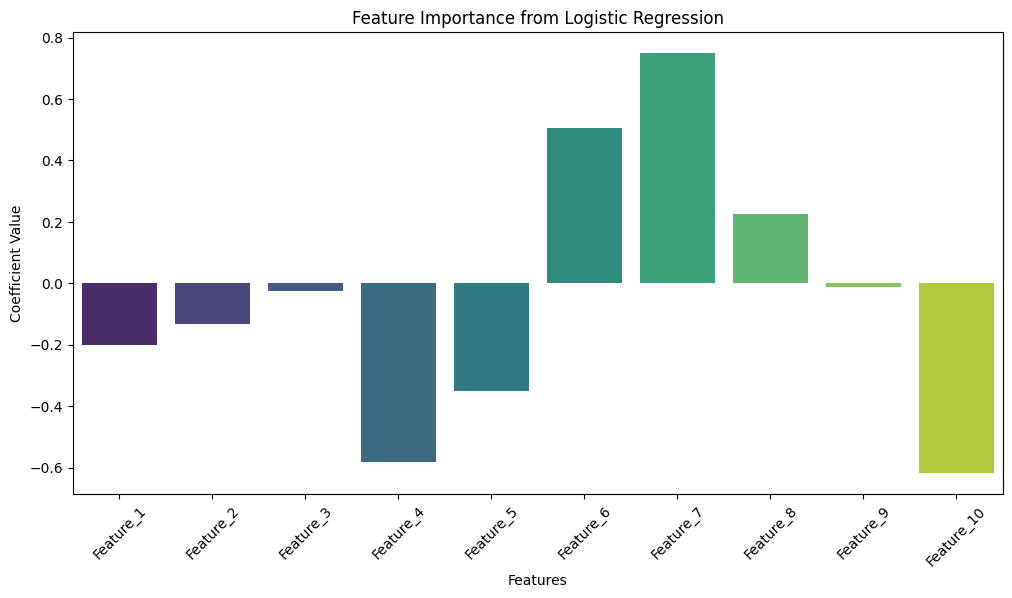

In [17]:
# %% [markdown]
"""
# Cell 14: Feature Importance and Model Interpretability

In materials science, understanding which features drive model predictions is crucial.
Here we analyze feature importance using Logistic Regression coefficients on the limited labeled data.
"""

# %% [code]
# Cell 14: Feature Importance Analysis
# Train a logistic regression model on the high-dimensional labeled data
X_hd_labeled = X_hd[y_hd_semi != -1]
y_hd_labeled = y_hd[y_hd_semi != -1]

lr_hd = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_hd.fit(X_hd_labeled, y_hd_labeled)

# Get the coefficients (importance of each feature)
feature_importance = lr_hd.coef_[0]
feature_names = [f"Feature_{i+1}" for i in range(n_features_hd)]

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_names, y=feature_importance, palette='viridis')
plt.title("Feature Importance from Logistic Regression")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45)
plt.show()

In [18]:
# %% [markdown]
"""
# Cell 15: Saving and Loading the Model

Finally, we demonstrate how to save and load the trained semi-supervised model.
This is useful for applying the model to new data or integrating it into a larger materials science
discovery pipeline.
"""

# %% [code]
# Cell 15: Save and Load Model
import joblib

# Save the LabelSpreading model
model_filename = "label_spreading_model.pkl"
joblib.dump(label_spread, model_filename)
print(f"LabelSpreading model saved as {model_filename}.")

# Load the model to verify
loaded_model = joblib.load(model_filename)
print("Model loaded successfully. Predictions remain consistent:")
print("First 10 predictions:", loaded_model.transduction_[:10])

LabelSpreading model saved as label_spreading_model.pkl.
Model loaded successfully. Predictions remain consistent:
First 10 predictions: [0 0 0 1 0 0 1 0 1 0]


In [19]:

# %% [markdown]
"""
# Cell 16: Summary and Future Directions

This notebook has walked you through a comprehensive workflow for applying semi-supervised learning
to materials science problems:
- We simulated synthetic materials data.
- Visualized the labeled and unlabeled data.
- Applied semi-supervised learning (LabelSpreading) and compared it to a fully supervised model.
- Explored various visualization techniques (PCA, t-SNE) and interpretability methods.
- Simulated a self-training approach and discussed model evaluation.

In real-world applications, integrating these techniques with experimental data and simulation results
can lead to faster discovery and improved performance in predicting material properties.

As a future step, consider exploring more advanced semi-supervised methods, integrating domain-specific
features, or coupling these approaches with active learning to guide experimental design.

Thank you for following along!
"""

# %% [markdown]
"""
# End of Notebook

This concludes our comprehensive notebook on semi-supervised learning in materials science.
We encourage you to experiment with the parameters, extend the dataset, and integrate additional
visualization or interpretability techniques. Happy coding and discovering!
"""


'\n# End of Notebook\n\nThis concludes our comprehensive notebook on semi-supervised learning in materials science.\nWe encourage you to experiment with the parameters, extend the dataset, and integrate additional\nvisualization or interpretability techniques. Happy coding and discovering!\n'